In [1]:
using Statistics
using LinearAlgebra
using NLsolve
using Optim
using DifferentialEquations
using JLD2
using FileIO
using LightGraphs
using GraphPlot
using DelimitedFiles

using PyCall
using PyPlot
PyPlot.svg(true)

true

In [2]:
make_axes_locatable = pyimport("mpl_toolkits.axes_grid1").make_axes_locatable
gs = pyimport("matplotlib.gridspec")
cm = pyimport("matplotlib").cm
ListedColormap = pyimport("matplotlib.colors").ListedColormap

PyObject <class 'matplotlib.colors.ListedColormap'>

In [3]:
inset_axes = pyimport("mpl_toolkits.axes_grid1.inset_locator").inset_axes

PyObject <function inset_axes at 0x7f590d391310>

In [4]:
rdbu_vals = cm.get_cmap("RdBu", 256)

newcolors = rdbu_vals(LinRange(0.15, 0.85, 256))
RdBuShort = ListedColormap(newcolors, name="RdBuShort")
RdBuShort_r = ListedColormap(newcolors[end:-1:1,:], name="RdBuShort_r")

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/henrik/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


# Figure 1

(a) Corresponds to Fig 2b in the Nicolau paper

In [4]:
function Rsqr_formula(κ, ς)
    0.5 + 2κ*ς^2*(κ^2 + 8ς^4 + 2)/( (κ^2 - 4)^2 + 16(κ^2 + 5)ς^4 + 64ς^8 )
end

function Rsqr_by_ς(κ, ς)
    -4ς*κ*(-32 + 512ς^12 + 6κ^4 - κ^6 + 64ς^8*(κ^2 - 4) - 8ς^4*(28 - 38κ^2 + κ^4))/( 64ς^8 + (κ^2 - 4)^2 + 16ς^4*(κ^2 + 5)^2 )^2
end

Rsqr_by_ς (generic function with 1 method)

In [5]:
function solve_two_osc_numerical(κ, ς; tmax=20000.0, dt=0.001)
    function f(du, u, p, t)
        du .= 1.0 .- κ*sin.(u)
    end
    
    function g(du, u, p, t)
        du .= √(2)*ς
    end
    
    u0 = [0.0]
    tspan = (0.0, tmax)
    prob = SDEProblem(f, g, u0, tspan)
    
    sol = solve(prob, EM(), dt=dt, saveat=0.5tmax:dt:tmax)
end

function Rsqr_from_sol_two_osc(sol)
    u = hcat(sol.u...)
    Rsqrs = 0.5 .+ 0.5cos.(u)
    
    # use trapezoid rule to integrate
    Rsqr = 0.0
    for i=1:length(sol)-1
        Rsqr += 0.5*(sol.t[i+1] - sol.t[i])*(Rsqrs[i+1] .+ Rsqrs[i])/(sol.t[end] - sol.t[1])
    end
    
    Rsqr
end

Rsqr_from_sol_two_osc (generic function with 1 method)

In [6]:
function ρ_opt_approx(Σ, κ)
    # analytical approximation
    q = 1 - Σ^-2 *( 1 - 23κ^2/100)
    
    if q > 1
        1.0
    elseif q < -1
        -1.0
    else
        q
    end
end

function ς_opt_approx2(κ)
    # numerical approximation
    
    function root!(F, x)
        F[1] = Rsqr_by_ς(κ, x[1])
    end
    
    sln = nlsolve(root!, [0.5], autodiff=:forward)
    
    ς_opt = sln.zero[1]
end

function ρ_opt_approx2(Σ, κ)
    # numerical approximation
    q = 1 - Σ^-2 * ς_opt_approx2(κ)^2
    
    if q > 1
        1.0
    elseif q < -1
        -1.0
    else
        q
    end
end

function ρ_opt_generic(Σ, α, κ)
    # numerical approximation
    q = - Σ^-2 * ς_opt_approx2(κ)^2 / (1 - α^2) + (1 + α^2)/(1 - α^2)
    
    if q > 1
        1.0
    elseif q < -1
        -1.0
    else
        q
    end
end

function ς_fun(Σ, α, ρ)
    Σ * sqrt(1 - ρ + α^2 * (1 + ρ))
end

ς_fun (generic function with 1 method)

In [7]:
n = 512
ρ_opt = zeros(n, n)

κs_rho = LinRange(0.01, 1.01, n)
Σs_rho = LinRange(0.01, 2.02, n)


for (i, κ) in enumerate(κs_rho)
    for (j, Σ) in enumerate(Σs_rho)
        ρ_opt[i,j] = ρ_opt_approx2(Σ, κ)
    end
end

In [8]:
n = 512
ρ_opt_gen = zeros(n, n)

κs_rho = LinRange(0.01, 1.0, n)
Σs_rho = LinRange(0.01, 2.1, n)


for (i, κ) in enumerate(κs_rho)
    for (j, Σ) in enumerate(Σs_rho)
        ρ_opt_gen[i,j] = ρ_opt_generic(Σ, 0.5, κ)
    end
end

In [ ]:
# this and the following cell are slow and can be loaded from the data jld2

κs = LinRange(0.01, 2.0, 50)
ς1s = LinRange(0.0, 0.8, 4)
Rsqrs = []

for ς in ς1s
    
    Rsqr_curve = []
    for κ in κs
        sln = solve_two_osc_numerical(κ, ς)
        Rsqr = Rsqr_from_sol_two_osc(sln)
        push!(Rsqr_curve, Rsqr)
    end
    
    push!(Rsqrs, Rsqr_curve)
end

In [ ]:
κ = 0.9
ςs = LinRange(0.0, 4.0, 40)
Rsqrs_fix_κ = []

for ς in ςs
    sln = solve_two_osc_numerical(κ, ς)
    Rsqr = Rsqr_from_sol_two_osc(sln)
    
    push!(Rsqrs_fix_κ, Rsqr)
end

In [ ]:
# jldsave("data/figure_1_data.jld2"; κs, ς1s, Rsqrs, κ, ςs, Rsqrs_fix_κ)

In [10]:
fig1 = load("data/figure_1_data.jld2")
κs, ς1s, Rsqrs, κ, ςs, Rsqrs_fix_κ = fig1["κs"], fig1["ς1s"], fig1["Rsqrs"], fig1["κ"], fig1["ςs"], fig1["Rsqrs_fix_κ"]

(range(0.01, stop=2.0, length=50), range(0.0, stop=0.8, length=4), Any[Any[0.4999698614702808, 0.49999771667098325, 0.4999708449172954, 0.5000687079687084, 0.5000590881716273, 0.49997548380832185, 0.4999338631682582, 0.4999828393555716, 0.5000318952959142, 0.4999750194851585  …  0.8955017159336309, 0.9011285959818175, 0.9062907345001269, 0.911040620602069, 0.9154231392465051, 0.9194769230642985, 0.923235422303548, 0.9267277535429973, 0.9299793874650322, 0.9330127016594468], Any[0.5001689584900264, 0.5030518119234266, 0.5014947944095324, 0.5013918241875467, 0.5016314752907397, 0.5036009263593866, 0.5047006426219316, 0.5062006656352381, 0.5060156678580313, 0.5054684683293975  …  0.8782629218898916, 0.8847655032063797, 0.8895463380989119, 0.8957518431045453, 0.9017599015504666, 0.9047395085100324, 0.9075337596023344, 0.9143953199188595, 0.9166390252083048, 0.9210574145050097], Any[0.5013479870537537, 0.509774536358027, 0.5075711095437075, 0.5085229814888194, 0.5101708351321624, 0.51697275

In [11]:
function meshgrid(x, y)
    X = [i for i in x, j in 1:length(y)]
    Y = [j for i in 1:length(x), j in y]
    return X, Y
end

meshgrid (generic function with 1 method)

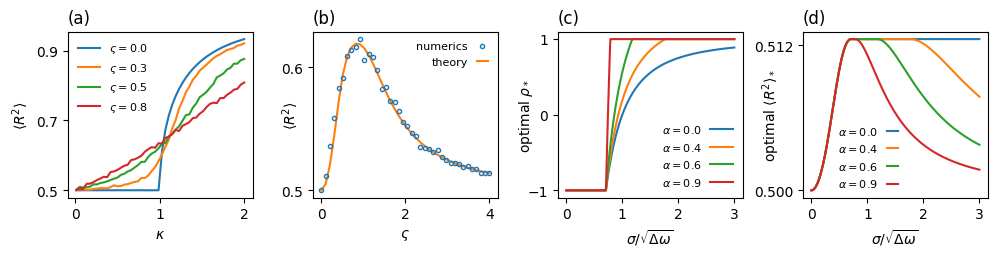

In [29]:
fig, axs = subplots(1, 4, figsize=(10, 2.6))

ax = axs[1]

for (ς, Rsqr) in zip(ς1s, Rsqrs)
    l = ax.plot(κs, Rsqr, "-", mfc="none", label="\$\\varsigma = $(round(ς, sigdigits=1))\$")
#     col = l[1].get_color()
#     ax.plot(κs[1:20], Rsqr_formula.(κs[1:20], ς), color=col)
end

ax.legend(frameon=false, fontsize=8)

ax.set_yticks([0.5, 0.7, 0.9])

ax.set_xlabel(L"$\kappa$")
ax.set_ylabel(L"$\langle R^2 \rangle$")
ax.set_title("(a)", loc="left")


ax = axs[2]

κ = 0.9
ax.plot(ςs, Rsqrs_fix_κ, ".", mfc="none", label="numerics", zorder=100)
ax.plot(ςs, Rsqr_formula.(κ, ςs), label="theory")


ax.legend(frameon=false, fontsize=8, markerfirst=false, handlelength=1)

ax.set_yticks([0.5, 0.6])


ax.set_xlabel(L"$\varsigma$")
ax.set_ylabel(L"$\langle R^2 \rangle$", labelpad=-14)
ax.set_title("(b)", loc="left")

ax = axs[3]

Σs = LinRange(0, 3, 500)
ax.plot(Σs, ρ_opt_generic.(Σs, 0.0, 0.1), label=L"$\alpha=0.0$")
ax.plot(Σs, ρ_opt_generic.(Σs, 0.4, 0.1), label=L"$\alpha=0.4$")
ax.plot(Σs, ρ_opt_generic.(Σs, 0.6, 0.1), label=L"$\alpha=0.6$")
ax.plot(Σs, ρ_opt_generic.(Σs, 0.9, 0.1), label=L"$\alpha=0.9$")
ax.legend(frameon=false, fontsize=8, markerfirst=false)

# check that the plots are ok! they are :)
# ax.axvline((1 - 23*(0.1)^2/100)/(sqrt(2)*0.6))

ax.set_yticks([-1, 0, 1])

ax.set_xlabel(L"$\sigma/\sqrt{\Delta\omega}$")
ax.set_ylabel(L"optimal $\rho_*$", labelpad=-5)
ax.set_title("(c)", loc="left")

ax = axs[4]

# Old version
# X, Y = meshgrid(Σs_rho .- 0.5(Σs_rho[1] + Σs_rho[2]), κs_rho .- 0.5(κs_rho[1] + κs_rho[2]))
# sc = ax.pcolormesh(X, Y, ρ_opt', rasterized=true, vmin=-1, vmax=1, cmap=RdBuShort_r)
# ax.set_xlabel(L"$\sigma/\Delta\omega$")
# ax.set_ylabel(L"$\kappa$", labelpad=-8)

# ax.set_yticks([0, 1])

# ax.set_title("(d)", loc="left")

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.07)

# cb = fig.colorbar(sc, cax=cax, ticks=[-1, 0, 1])
# cb.ax.set_title(L"$\rho_*$", fontsize=10)

# Σs = LinRange(0, 4, 200)

# check that the plots are correct!

# ax.axvline((1 - 23*(0.1)^2/100)/sqrt(2), color="k", ls="--")
# ax.axvline((1 - 23*(0.1)^2/100)/(sqrt(2)*0.4), color="C1", ls="--")
# ax.axvline((1 - 23*(0.1)^2/100)/(sqrt(2)*0.6), color="C2", ls="--")
# ax.axvline((1 - 23*(0.1)^2/100)/(sqrt(2)*0.9), color="C3", ls="--")

ax.plot(Σs, Rsqr_formula.(0.1, ς_fun.(Σs, 0.0, ρ_opt_generic.(Σs, 0.0, 0.1))), label=L"$\alpha=0.0$")
ax.plot(Σs, Rsqr_formula.(0.1, ς_fun.(Σs, 0.4, ρ_opt_generic.(Σs, 0.4, 0.1))), label=L"$\alpha=0.4$")
ax.plot(Σs, Rsqr_formula.(0.1, ς_fun.(Σs, 0.6, ρ_opt_generic.(Σs, 0.6, 0.1))), label=L"$\alpha=0.6$")
ax.plot(Σs, Rsqr_formula.(0.1, ς_fun.(Σs, 0.9, ρ_opt_generic.(Σs, 0.9, 0.1))), label=L"$\alpha=0.9$")
# ax.plot(Σs, ρ_opt_generic.(Σs, 0.3, 0.01), label=L"$\alpha=0.3$")
# ax.plot(Σs, ρ_opt_generic.(Σs, 0.5, 0.01), label=L"$\alpha=0.5$")
# ax.plot(Σs, ρ_opt_generic.(Σs, 0.9, 0.01), label=L"$\alpha=0.9$")
ax.legend(frameon=false, fontsize=8, markerfirst=false, handlelength=1, bbox_to_anchor=(0.1, 0., 0.5, 0.5))


ax.set_yticks([0.5, 0.512])

ax.set_xlabel(L"$\sigma/\sqrt{\Delta\omega}$")
ax.set_ylabel(L"optimal $\langle R^2 \rangle_*$", labelpad=-20)
ax.set_title("(d)", loc="left")

fig.tight_layout(pad=0.8)

# fig.savefig("../figures/figure_1.svg", bbox_inches="tight")
# fig.savefig("../figures/figure_1.pdf", bbox_inches="tight")

# Figure 2
Chain graphs

In [38]:
data_34_a = load("data/periodic_line_34_fix_Cii_K_2.0.jld2")
C_34 = data_34_a["Copt"]

data_35_a = load("data/periodic_line_35_fix_Cii_K_2.0.jld2")
C_35_a = data_35_a["Copt"]

# data_ts = load("data/periodic_line_34_fix_Cii_K_2.0.jld2")
# tdata_ts = load("data/periodic_line_34_fix_Cii_K_2.0_sigma_0.5_timeseries.jld2")

# ts_optval = data_ts["optval"]
# ts_optval_uf = data_ts["optval_uniform"]
# R0_ts = data_ts["R0"]
# Rs = tdata_ts["Rsqrs_avg"]
# Rs_uf = tdata_ts["Rsqrs_avg_unif"]
# σ_ts = tdata_ts["σ"]
# ts = tdata_ts["ts"]

σdata = load("data/periodic_line_10_fix_Cii_K_2.0_sigma_series.jld2")
σoptval = σdata["optval"]
σopt_uf = σdata["optval_uniform"]
σRsqrs_opt = σdata["Rsqrs_opt"]
σRsqrs_uf = σdata["Rsqrs_uni"]
σs = σdata["σs"]
σR0 = σdata["R0"];

In [41]:
# larger data

data_ts = load("data/periodic_line_54_fix_Cii_K_2.0.jld2")
tdata_ts = load("data/periodic_line_54_fix_Cii_K_2.0_sigma_0.5_timeseries.jld2")

ts_optval = data_ts["optval"]
ts_optval_uf = data_ts["optval_uniform"]
R0_ts = data_ts["R0"]
Rs = tdata_ts["Rsqrs_avg"]
Rs_uf = tdata_ts["Rsqrs_avg_unif"]
σ_ts = tdata_ts["σ"]
ts = tdata_ts["ts"]

1000001-element Vector{Float64}:
     0.0
     0.01
     0.02
     0.03
     0.04
     0.05
     0.060000000000000005
     0.07
     0.08
     0.09
     0.09999999999999999
     0.10999999999999999
     0.11999999999999998
     ⋮
  9999.890000171854
  9999.900000171854
  9999.910000171854
  9999.920000171855
  9999.930000171855
  9999.940000171855
  9999.950000171855
  9999.960000171855
  9999.970000171856
  9999.980000171856
  9999.990000171856
 10000.0

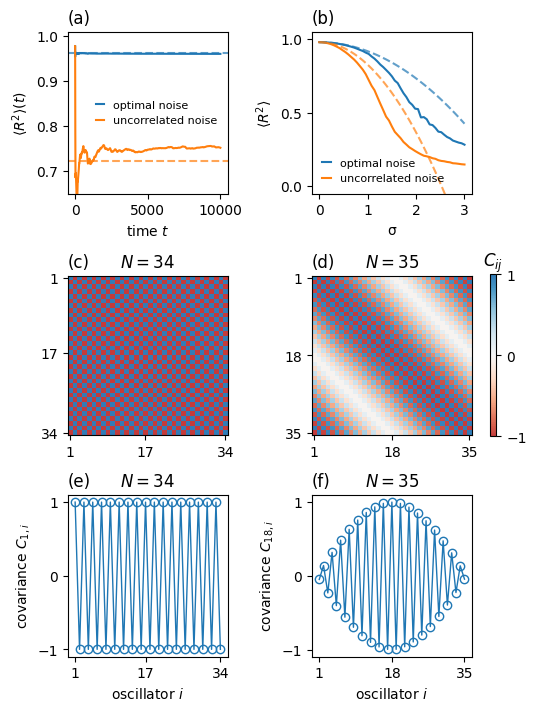

In [45]:
fig = figure(figsize=(5.25, 7), constrained_layout=true)

spec = fig.add_gridspec(3, 3, width_ratios=[1, 1, 0.04], wspace=0.05)

ax = fig.add_subplot(spec[2,1])
cmin, cmax = abs(minimum(C_34)), abs(maximum(C_34))
cmx = maximum([cmin, cmax])
sc = ax.matshow(C_34, cmap=RdBuShort, vmin=-cmx, vmax=cmx)
# fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, label="covariance matrix")
ax.set_xticks([0, 16, 33])
ax.set_yticks([0, 16, 33])

ax.xaxis.set_ticks_position("bottom")

ax.set_xticklabels([1, 17, 34])
ax.set_yticklabels([1, 17, 34])

ax.set_title("(c)", loc="left")
ax.set_title(L"$N=34$")


ax = fig.add_subplot(spec[3,1])
ax.plot(1:34, C_34[:,1], "o-", lw=1, mfc="none")

ax.set_xticks([1, 17, 34])
ax.set_yticks([-1, 0, 1])

ax.set_xlabel(L"oscillator $i$")
ax.set_ylabel(L"covariance $C_{1,i}$")

ax.set_title("(e)", loc="left")
ax.set_title(L"N=34")



ax = fig.add_subplot(spec[2,2])
cmin, cmax = abs(minimum(C_35_a)), abs(maximum(C_35_a))
cmx = maximum([cmin, cmax])
sc = ax.matshow(C_35_a, cmap=RdBuShort, vmin=-cmx, vmax=cmx)

cax = fig.add_subplot(spec[2,3])
cb = fig.colorbar(sc, cax=cax, fraction=0.046, pad=0.04, ticks=[-1, 0, 1])
cb.ax.set_title(L"C_{ij}")
ax.set_xticks([0, 17, 34])
ax.set_yticks([0, 17, 34])

ax.xaxis.set_ticks_position("bottom")

ax.set_xticklabels([1, 18, 35])
ax.set_yticklabels([1, 18, 35])

ax.set_title("(d)", loc="left")
ax.set_title(L"$N=35$")



ax = fig.add_subplot(spec[3,2])

ax.plot(1:35, C_35_a[:,18], "o-", lw=1, mfc="none")

ax.set_xticks([1, 18, 35])
ax.set_yticks([-1, 0, 1])

ax.set_xlabel(L"oscillator $i$")
ax.set_ylabel(L"covariance $C_{18,i}$")

ax.set_title("(f)", loc="left")
ax.set_title(L"N=35")



ax = fig.add_subplot(spec[1,1])

ax.axhline(R0_ts + 0.5σ_ts^2*ts_optval, color="C0", ls="--", alpha=0.7)
ax.axhline(R0_ts + 0.5σ_ts^2*ts_optval_uf, color="C1", ls="--", alpha=0.7)

ax.plot(ts, Rs, color="C0", label="optimal noise")
ax.plot(ts, Rs_uf, color="C1", label="uncorrelated noise")

ax.set_ylim(0.65, 1.01)

ax.set_xticks([0, 5000, 10000])
ax.set_yticks([0.7, 0.8, 0.9, 1.0])

ax.set_xlabel(L"time $t$")
ax.set_ylabel(L"$\langle{R^2}\rangle(t) $")

ax.legend(frameon=false, fontsize=8, markerfirst=true, handlelength=0.8, loc="best")

ax.set_title("(a)", loc="left")



ax = fig.add_subplot(spec[1,2])

ax.plot(σs, σRsqrs_opt, c="C0", label="optimal noise")
ax.plot(σs, σRsqrs_uf, c="C1", label="uncorrelated noise")

ax.plot(σs, σR0 .+ 0.5σs.^2 .* σoptval, c="C0", ls="--", alpha=0.7)
ax.plot(σs, σR0 .+ 0.5σs.^2 .* σopt_uf, c="C1", ls="--", alpha=0.7)

ax.set_yticks([0, 0.5, 1])
ax.set_xticks([0,1,2,3])

ax.set_ylim(-0.05, 1.05)

ax.set_xlabel("σ")
ax.set_ylabel(L"$\langle{R^2}\rangle$")

ax.legend(frameon=false, fontsize=8, markerfirst=true, handlelength=0.8, loc="best")

ax.set_title("(b)", loc="left")


fig.tight_layout(h_pad=0.5)
fig.savefig("../figures/figure_2.svg", bbox_inches="tight")
fig.savefig("../figures/figure_2.pdf", bbox_inches="tight")

# Figure 3

Analysis of a 5x5 and 6x6 grid graph

In [44]:
data_6x6 = load("data/periodic_grid_6x6_fix_Cii.jld2")
C_6x6 = data_6x6["Copt"]

data_7x7 = load("data/periodic_grid_7x7_fix_Cii.jld2")
C_7x7 = data_7x7["Copt"];

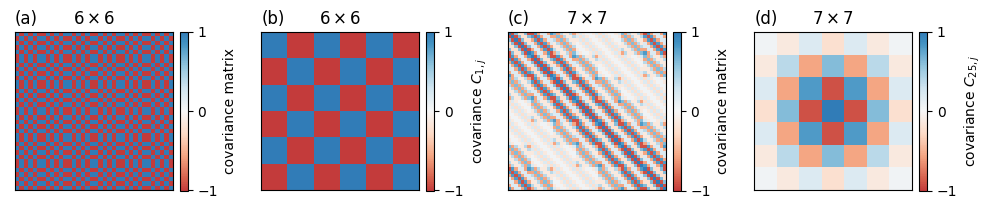

In [48]:
fig, axs = subplots(1, 4, figsize=(10, 2.6))

ax = axs[1]
cmin, cmax = abs(minimum(C_6x6)), abs(maximum(C_6x6))
cm = maximum([cmin, cmax])
sc = ax.matshow(C_6x6, cmap=RdBuShort, vmin=-cm, vmax=cm)
fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, label="covariance matrix", ticks=[-1,0,1])
ax.set_xticks([])
ax.set_yticks([])

ax.set_title("(a)", loc="left")
ax.set_title(L"$6\times 6$")


ax = axs[2]
sc = ax.matshow(reshape(C_6x6[1,:], 6, 6)', cmap=RdBuShort, vmin=-cm, vmax=cm)
fig.colorbar(sc, ax=ax, label=L"covariance $C_{1,j}$", fraction=0.046, pad=0.04, ticks=[-1,0,1])
ax.set_xticks([])
ax.set_yticks([])

ax.set_title("(b)", loc="left")
ax.set_title(L"$6\times 6$")



ax = axs[3]
cmin, cmax = abs(minimum(C_7x7)), abs(maximum(C_7x7))
cm = maximum([cmin, cmax])
sc = ax.matshow(C_7x7, cmap=RdBuShort, vmin=-cm, vmax=cm)
fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, label="covariance matrix", ticks=[-1,0,1])
ax.set_xticks([])
ax.set_yticks([])

ax.set_title("(c)", loc="left")
ax.set_title(L"$7\times 7$")


ax = axs[4]
sc = ax.matshow(reshape(C_7x7[3*7+4,:], 7, 7)', cmap=RdBuShort, vmin=-cm, vmax=cm)
fig.colorbar(sc, ax=ax, label=L"covariance $C_{25,j}$", fraction=0.046, pad=0.04, ticks=[-1,0,1])
ax.set_xticks([])
ax.set_yticks([])

ax.set_title("(d)", loc="left")
ax.set_title(L"$7\times 7$")


fig.tight_layout(pad=1)
fig.savefig("../figures/figure_3.svg", bbox_inches="tight")
fig.savefig("../figures/figure_3.pdf", bbox_inches="tight")

# Figure 5 - IEEE graphs

In [8]:
data_ieee_14 = load("data/ieee_14_fix_Cii.jld2")
C_ieee_14 = data_ieee_14["Copt"]

data_ieee_30 = load("data/ieee_30_fix_Cii.jld2")
C_ieee_30 = data_ieee_30["Copt"]

30×30 Matrix{Float64}:
  1.0         -0.856837    -0.996566    …  -0.0914589   -0.0920573
 -0.856837     1.0          0.811203       -0.0716836   -0.0712473
 -0.996566     0.811203     1.0             0.115183     0.115794
  0.969903    -0.705565    -0.986728       -0.158726    -0.159344
  0.476016    -0.861295    -0.401563        0.212247     0.212094
 -0.28337     -0.250732     0.361687    …   0.298164     0.298486
 -0.275288     0.731518     0.194741       -0.25353     -0.253508
  0.28617      0.226153    -0.36073        -0.323453    -0.3235
 -0.00708586  -0.00463962   0.00881081      0.00211906   0.00158725
  0.148462     0.111352    -0.186732       -0.0534064   -0.0539735
 -0.00619569  -0.00503783   0.00785518  …   0.00119105   0.00177917
 -0.0494991    0.0365558    0.0503009       0.00428304   0.00360699
 -0.0491527    0.0370074    0.0498203       0.00374887   0.00441127
  ⋮                                     ⋱               
  0.146334     0.107531    -0.183703       -0.0496312

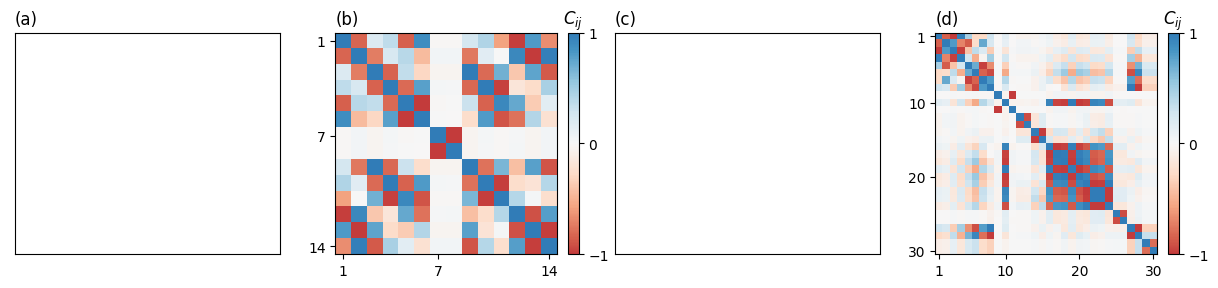

In [13]:
fig, axs = subplots(1, 4, figsize=(12, 2.6))

ax = axs[1]
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("(a)", loc="left")



ax = axs[2]

Cc = C_ieee_14

cmin, cmax = abs(minimum(Cc)), abs(maximum(Cc))
cm = maximum([cmin, cmax])
sc = ax.matshow(Cc, cmap=RdBuShort, vmin=-cm, vmax=cm)
cb = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, ticks=[-1,0,1])
cb.ax.set_title(L"C_{ij}")
ax.set_xticks([0, 6, 13])
ax.set_yticks([0, 6, 13])

ax.xaxis.set_ticks_position("bottom")

ax.set_xticklabels([1, 7, 14])
ax.set_yticklabels([1, 7, 14])

ax.set_title("(b)", loc="left")


ax = axs[3]

ax.set_xticks([])
ax.set_yticks([])

ax.set_title("(c)", loc="left")


ax = axs[4]

Cc = C_ieee_30

cmin, cmax = abs(minimum(Cc)), abs(maximum(Cc))
cm = maximum([cmin, cmax])
sc = ax.matshow(Cc, cmap=RdBuShort, vmin=-cm, vmax=cm)
cb = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, ticks=[-1,0,1])
cb.ax.set_title(L"C_{ij}")
ax.set_xticks([0, 9, 19, 29])
ax.set_yticks([0, 9, 19, 29])

ax.xaxis.set_ticks_position("bottom")

ax.set_xticklabels([1, 10, 20, 30])
ax.set_yticklabels([1, 10, 20, 30])

ax.set_title("(d)", loc="left")


fig.tight_layout(pad=0.)
fig.savefig("../figures/figure_5.svg", bbox_inches="tight")
# fig.savefig("../figures/figure_5.pdf", bbox_inches="tight")

# Supplemental Figure: Comparing formula with numerical solution of the FP equation

In [55]:
ς_opt_approx(κ) = 1 - 23κ^2/100 #- 1757κ^4/25000
ς_opt_approx2(κ) = 1 - 23κ^2/100 - 1757κ^4/25000
Rsqr_opt_approx(κ) = 1/2 + κ/8
Rsqr_opt_approx2(κ) = 1/2 + κ/8 + κ^3/160

fp_data = readdlm("data/fokker_planck_optimal_data.csv", ',')

fp_κs = LinRange(0, 1, 200)
fp_κ = fp_data[:,1]
fp_ς2 = fp_data[:,2]
fp_R2 = fp_data[:,3];

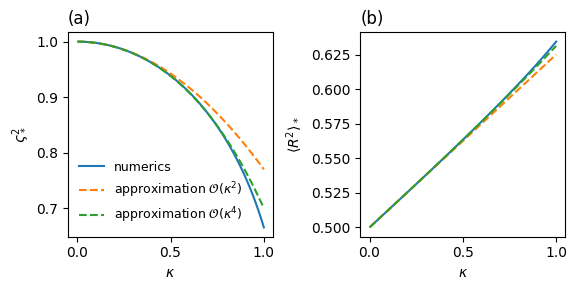

In [64]:
fig, axs = subplots(1, 2, figsize=(6, 3))

ax = axs[1]
ax.plot(fp_κ, fp_ς2, label="numerics")
ax.plot(fp_κs, ς_opt_approx.(fp_κs), "--", label=L"approximation $\mathcal{O}(\kappa^2)$")
ax.plot(fp_κs, ς_opt_approx2.(fp_κs), "--", label=L"approximation $\mathcal{O}(\kappa^4)$")

ax.legend(frameon=false, fontsize=9, handlelength=2)

ax.set_xlabel(L"\kappa")
ax.set_ylabel(L"\varsigma^2_*")
ax.set_title("(a)", loc="left")

ax = axs[2]
ax.plot(fp_κ, fp_R2, label="numerics")
ax.plot(fp_κs, Rsqr_opt_approx.(fp_κs), "--", label=L"approximation $\mathcal{O}(\kappa)$")
ax.plot(fp_κs, Rsqr_opt_approx2.(fp_κs), "--", label=L"approximation $\mathcal{O}(\kappa^3)$")


# ax.legend(frameon=false, fontsize=9, handlelength=1, loc="lower right")

ax.set_xlabel(L"\kappa")
ax.set_ylabel(L"\langle R^2\rangle_*")
ax.set_title("(b)", loc="left")

fig.tight_layout()
fig.savefig("../figures/supp_approximation.svg", bbox_inches="tight")
fig.savefig("../figures/supp_approximation.pdf", bbox_inches="tight")

# New Figure: Numerics for chains beyond the synchronized regime

In [5]:
element(i,j) = get(gs, (i,j))
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j)

function draw_C(ax, Cc)
    cmin, cmax = abs(minimum(Cc)), abs(maximum(Cc))
    cm = maximum([cmin, cmax])
    sc = ax.matshow(Cc, cmap=RdBuShort, vmin=-cm, vmax=cm)
#     cb = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, ticks=[-1,0,1])
#     cb.ax.set_title(L"C_{ij}")
    ax.set_xticks([0, 6, 13])
    ax.set_yticks([0, 6, 13])

    ax.xaxis.set_ticks_position("bottom")

    ax.set_xticklabels([1, 7, 14])
    ax.set_yticklabels([1, 7, 14])
    
    sc
end

function draw_C_noticks(ax, Cc)
    cmin, cmax = abs(minimum(Cc)), abs(maximum(Cc))
    cm = maximum([cmin, cmax])
    sc = ax.matshow(Cc, cmap=RdBuShort, vmin=-cm, vmax=cm)
#     cb = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, ticks=[-1,0,1])
#     cb.ax.set_title(L"C_{ij}")

    ax.xaxis.set_ticks_position("bottom")
    
    sc
end

draw_C_noticks (generic function with 1 method)

In [6]:
# data_chain_9 = load("data/chain_Ks_n_1_m_9_sigma_0.5.jld2")
# chain_9_R0s       = data_chain_9["R0s"]
# chain_9_Rsqrs_no  = data_chain_9["Rsqrs_no"]
# chain_9_Rsqrs_opt = data_chain_9["Rsqrs_opt"]
# chain_9_Rsqrs_uni = data_chain_9["Rsqrs_uni"]
# chain_9_Ks        = data_chain_9["Ks"]
# chain_9_σ         = data_chain_9["σ"]

# data_chain_10 = load("data/chain_Ks_n_1_m_10_sigma_0.5.jld2")
# chain_10_R0s       = data_chain_10["R0s"]
# chain_10_Rsqrs_no  = data_chain_10["Rsqrs_no"]
# chain_10_Rsqrs_opt = data_chain_10["Rsqrs_opt"]
# chain_10_Rsqrs_uni = data_chain_10["Rsqrs_uni"]
# chain_10_Ks        = data_chain_10["Ks"]
# chain_10_σ         = data_chain_10["σ"]

# TODO: Sigma = 0.2
data_chain_11 = load("data/chain_Ks_n_1_m_11_sigma_0.5_2.jld2")
chain_11_R0s       = data_chain_11["R0s"]
chain_11_Rsqrs_no  = data_chain_11["Rsqrs_no"]
chain_11_Rsqrs_opt = data_chain_11["Rsqrs_opt"]
chain_11_Rsqrs_uni = data_chain_11["Rsqrs_uni"]
chain_11_Ks        = data_chain_11["Ks"]
chain_11_σ         = data_chain_11["σ"]

data_chain_12 = load("data/chain_Ks_n_1_m_12_sigma_0.5_2.jld2")
chain_12_R0s       = data_chain_12["R0s"]
chain_12_Rsqrs_no  = data_chain_12["Rsqrs_no"]
chain_12_Rsqrs_opt = data_chain_12["Rsqrs_opt"]
chain_12_Rsqrs_uni = data_chain_12["Rsqrs_uni"]
chain_12_Ks        = data_chain_12["Ks"]
chain_12_σ         = data_chain_12["σ"]

data_chain_11_sigma = load("data/chain_sigmas_n_1_m_11_3.jld2")
σs_chain_11 = collect(data_chain_11_sigma["σs"])
Rsqr_no_sigma_11 = data_chain_11_sigma["Rsqrs_no"][1]
Rsqr_uni_sigma_11 = data_chain_11_sigma["Rsqrs_uni"]
Rsqr_opt_sigma_11 = data_chain_11_sigma["Rsqrs_opt"];

data_chain_12_sigma = load("data/chain_sigmas_n_1_m_12_3.jld2")
σs_chain_12 = collect(data_chain_12_sigma["σs"])
Rsqr_no_sigma_12 = data_chain_12_sigma["Rsqrs_no"][1]
Rsqr_uni_sigma_12 = data_chain_12_sigma["Rsqrs_uni"]
Rsqr_opt_sigma_12 = data_chain_12_sigma["Rsqrs_opt"];

In [15]:
# find the critical K values
i_crit_11 = findfirst(isfinite.(chain_11_R0s))
K_crit_11 = 0.5(chain_11_Ks[i_crit_11] + chain_11_Ks[i_crit_11-1])

i_crit_12 = findfirst(isfinite.(chain_12_R0s))
K_crit_12 = 0.5(chain_12_Ks[i_crit_12] + chain_12_Ks[i_crit_12-1])

0.34462000000000004

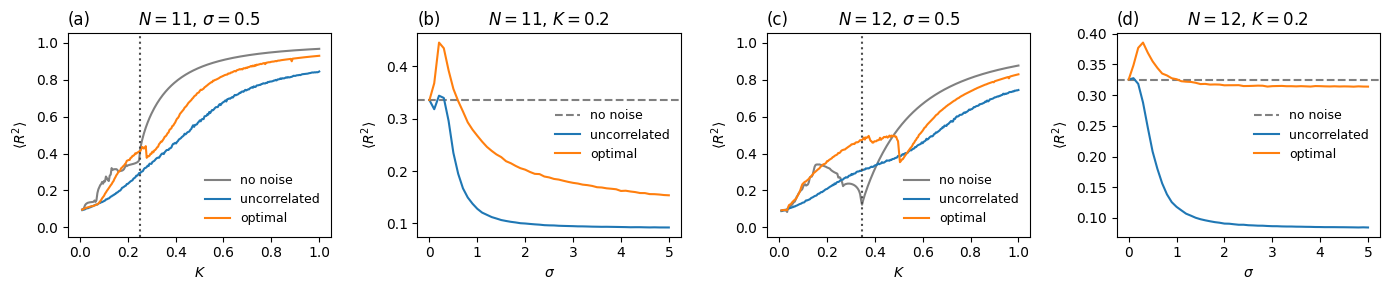

In [23]:
fig, axs = subplots(1, 4, figsize=(14, 3))

ax = axs[1]
ax.plot(chain_11_Ks, chain_11_Rsqrs_no, color="0.5", label="no noise")
ax.plot(chain_11_Ks, chain_11_Rsqrs_uni, label="uncorrelated")
ax.plot(chain_11_Ks, chain_11_Rsqrs_opt, label="optimal")
ax.axvline(K_crit_11, color="0.3", linestyle=":")

ax.legend(frameon=false, fontsize=9, handlelength=2)

ax.set_ylim(-0.05, 1.05)
ax.set_xlim(-0.05, 1.05)

ax.set_xlabel(L"K")
ax.set_ylabel(L"\langle R^2 \rangle")
ax.set_title("(a)", loc="left")
ax.set_title(L"$N=11$, $\sigma=0.5$")


ax = axs[2]
ax.axhline(Rsqr_no_sigma_11, ls="--", c="0.5",  label="no noise")
ax.plot(σs_chain_11, Rsqr_uni_sigma_11, label="uncorrelated")
ax.plot(σs_chain_11, Rsqr_opt_sigma_11, label="optimal")

ax.set_xticks([0, 1,2,3,4,5])

ax.legend(frameon=false, fontsize=9, handlelength=2)

ax.set_xlabel(L"\sigma")
ax.set_ylabel(L"\langle R^2 \rangle")
ax.set_title("(b)", loc="left")
ax.set_title(L"$N=11$, $K=0.2$")


ax = axs[3]
# ax.plot(chain_12_Ks, chain_12_R0s, "k-", label="no noise, theory")
ax.plot(chain_12_Ks, chain_12_Rsqrs_no, color="0.5", label="no noise")
ax.plot(chain_12_Ks, chain_12_Rsqrs_uni, label="uncorrelated")
ax.plot(chain_12_Ks, chain_12_Rsqrs_opt, label="optimal")
ax.axvline(K_crit_12, color="0.3", linestyle=":")


ax.legend(frameon=false, fontsize=9, handlelength=2)

ax.set_ylim(-0.05, 1.05)
ax.set_xlim(-0.05, 1.05)


ax.set_xlabel(L"K")
ax.set_ylabel(L"\langle R^2 \rangle")
ax.set_title("(c)", loc="left")
ax.set_title(L"$N=12$, $\sigma=0.5$")


ax = axs[4]
ax.axhline(Rsqr_no_sigma_12, ls="--", c="0.5",  label="no noise")
ax.plot(σs_chain_12, Rsqr_uni_sigma_12, label="uncorrelated")
ax.plot(σs_chain_12, Rsqr_opt_sigma_12, label="optimal")

ax.set_xticks([0, 1,2,3,4,5])

ax.legend(frameon=false, fontsize=9, handlelength=2)


ax.set_xlabel(L"\sigma")
ax.set_ylabel(L"\langle R^2 \rangle")
ax.set_title("(d)", loc="left")
ax.set_title(L"$N=12$, $K=0.2$")

fig.tight_layout()
fig.savefig("../figures/supp_chain_numerics.svg", bbox_inches="tight")
fig.savefig("../figures/supp_chain_numerics.pdf", bbox_inches="tight")

# New Figure: Optimal matrices as a function of K

In [7]:
for i=1:250
@show i, data_chain_12["Copts"][i][1], data_chain_12["Ks"][i]
end

(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (1, NaN, 0.01)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (2, NaN, 0.01396)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (3, NaN, 0.01792)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (4, NaN, 0.02188)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (5, NaN, 0.025840000000000002)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (6, NaN, 0.0298)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (7, NaN, 0.03376)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (8, NaN, 0.037720000000000004)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (9, NaN, 0.04168)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (10, NaN, 0.04564)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (11, NaN, 0.0496)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12[

(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (111, 0.9999999999735605, 0.4456)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (112, 0.9999999999827808, 0.44956)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (113, 0.9999999999829657, 0.45352000000000003)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (114, 0.9999999999729791, 0.45748)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (115, 0.999999999984718, 0.46144)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (116, 0.9999999999924564, 0.46540000000000004)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (117, 0.9999999999863982, 0.46936)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (118, 0.9999999999958945, 0.47332)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (119, 0.9999999999928286, 0.47728)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (12

(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (211, 1.000000000004659, 0.8416)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (212, 1.0000000000029674, 0.84556)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (213, 1.0000000000056095, 0.8495199999999999)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (214, 0.9999999999979617, 0.85348)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (215, 0.9999999999990916, 0.85744)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (216, 1.0000000000067701, 0.8613999999999999)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (217, 1.0000000000127032, 0.86536)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (218, 1.0000000000267621, 0.86932)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (219, 1.0000000000081892, 0.87328)
(i, ((data_chain_12["Copts"])[i])[1], (data_chain_12["Ks"])[i]) = (220,

In [17]:
fig = figure(constrained_layout=true, figsize=(9, 6))
gs = fig.add_gridspec(2, 5, height_ratios=[2, 1], width_ratios=[1,1,1,1,0.05])

ax1 = fig.add_subplot(element(0, slice(0, 5)))

Ks = data_chain_9["Ks"]
R0s = data_chain_9["R0s"]
σ = data_chain_9["σ"]
optvals = data_chain_9["optvals"]
ax1.plot(Ks, R0s, label="noise-free")
ax1.plot(Ks, R0s .+ 0.5*(σ^2)*optvals, label="optimal noise, σ=$(σ)")

ax1.legend()
ax1.set_xlabel(L"coupling strength $K$")
ax1.set_ylabel(L"$\langle R^2 \rangle = R_0^2 + \frac{1}{2} \sigma^2 \operatorname{tr}(HE)$")

ax1.set_title("(a)", loc="left")
ax1.set_title(L"N=9")


ax2 = fig.add_subplot(gs[2,1])

i = 37
draw_C_noticks(ax2, data_chain_9["Copts"][i])
ax2.set_title("(b)", loc="left")
ax2.set_title("K = $(round(data_chain_9["Ks"][i], sigdigits=2))", loc="right")


ax3 = fig.add_subplot(gs[2,2])

i = 39
draw_C_noticks(ax3, data_chain_9["Copts"][i])
ax3.set_title("(c)", loc="left")
ax3.set_title("K = $(round(data_chain_9["Ks"][i], sigdigits=2))", loc="right")

ax4 = fig.add_subplot(gs[2,3])

i = 40
draw_C_noticks(ax4, data_chain_9["Copts"][i])
ax4.set_title("(d)", loc="left")
ax4.set_title("K = $(round(data_chain_9["Ks"][i], sigdigits=2))", loc="right")

ax5 = fig.add_subplot(gs[2,4])
ax6 = fig.add_subplot(gs[2,5])

i = 53
sc = draw_C_noticks(ax5, data_chain_9["Copts"][i])
ax5.set_title("(e)", loc="left")
ax5.set_title("K = $(round(data_chain_9["Ks"][i], sigdigits=2))", loc="right")

cb = fig.colorbar(sc, cax=ax6, ticks=[-1,0,1], shrink=0.15, use_gridspec=true)
cb.ax.set_title(L"C_{ij}")

fig.tight_layout()

fig.savefig("../figures/supp_optimal_K_dep_9.svg", bbox_inches="tight")
fig.savefig("../figures/supp_optimal_K_dep_9.pdf", bbox_inches="tight")

LoadError: UndefVarError: slice not defined

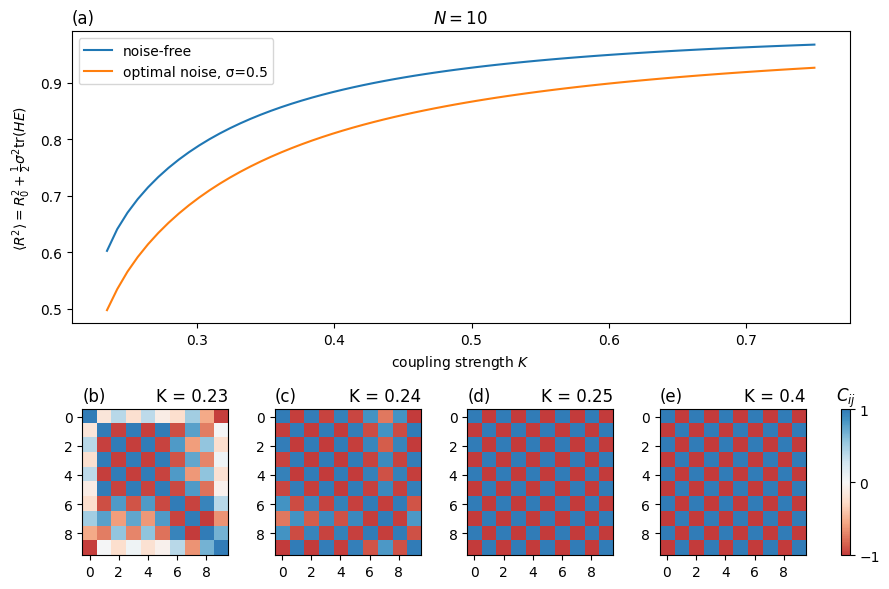

In [16]:
fig = figure(constrained_layout=true, figsize=(9, 6))
gs = fig.add_gridspec(2, 5, height_ratios=[2, 1], width_ratios=[1,1,1,1,0.05])

ax1 = fig.add_subplot(element(0, slice(0, 5)))

Ks = data_chain_10["Ks"]
R0s = data_chain_10["R0s"]
σ = data_chain_10["σ"]
optvals = data_chain_10["optvals"]
ax1.plot(Ks, R0s, label="noise-free")
ax1.plot(Ks, R0s .+ 0.5*(σ^2)*optvals, label="optimal noise, σ=$(σ)")

ax1.legend()
ax1.set_xlabel(L"coupling strength $K$")
ax1.set_ylabel(L"$\langle R^2 \rangle = R_0^2 + \frac{1}{2} \sigma^2 \operatorname{tr}(HE)$")

ax1.set_title("(a)", loc="left")
ax1.set_title(L"N=10")


ax2 = fig.add_subplot(gs[2,1])

i = 31
draw_C_noticks(ax2, data_chain_10["Copts"][i])
ax2.set_title("(b)", loc="left")
ax2.set_title("K = $(round(data_chain_10["Ks"][i], sigdigits=2))", loc="right")


ax3 = fig.add_subplot(gs[2,2])

i = 32
draw_C_noticks(ax3, data_chain_10["Copts"][i])
ax3.set_title("(c)", loc="left")
ax3.set_title("K = $(round(data_chain_10["Ks"][i], sigdigits=2))", loc="right")

ax4 = fig.add_subplot(gs[2,3])

i = 33
draw_C_noticks(ax4, data_chain_10["Copts"][i])
ax4.set_title("(d)", loc="left")
ax4.set_title("K = $(round(data_chain_10["Ks"][i], sigdigits=2))", loc="right")

ax5 = fig.add_subplot(gs[2,4])
ax6 = fig.add_subplot(gs[2,5])

i = 53
sc = draw_C_noticks(ax5, data_chain_10["Copts"][i])
ax5.set_title("(e)", loc="left")
ax5.set_title("K = $(round(data_chain_10["Ks"][i], sigdigits=2))", loc="right")

cb = fig.colorbar(sc, cax=ax6, ticks=[-1,0,1], shrink=0.15, use_gridspec=true)
cb.ax.set_title(L"C_{ij}")

fig.tight_layout()

fig.savefig("../figures/supp_optimal_K_dep_10.svg", bbox_inches="tight")
fig.savefig("../figures/supp_optimal_K_dep_10.pdf", bbox_inches="tight")

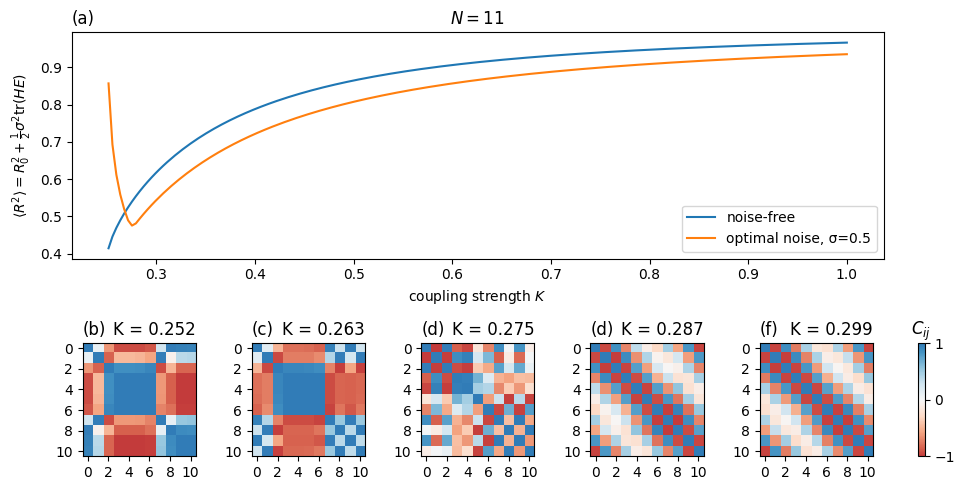

In [28]:
fig = figure(constrained_layout=true, figsize=(9.75, 5))
gs = fig.add_gridspec(2, 6, height_ratios=[2, 1], width_ratios=[1,1,1,1,1,0.05])

ax1 = fig.add_subplot(element(0, slice(0, 5)))

Ks = data_chain_11["Ks"]
R0s = data_chain_11["R0s"]
σ = data_chain_11["σ"]
optvals = data_chain_11["optvals"]
ax1.plot(Ks, R0s, label="noise-free")
ax1.plot(Ks, R0s .+ 0.5*(σ^2)*optvals, label="optimal noise, σ=$(σ)")

ax1.legend()
ax1.set_xlabel(L"coupling strength $K$")
ax1.set_ylabel(L"$\langle R^2 \rangle = R_0^2 + \frac{1}{2} \sigma^2 \operatorname{tr}(HE)$")

ax1.set_title("(a)", loc="left")
ax1.set_title(L"N=11")

ax2 = fig.add_subplot(gs[2,1])

i = 62
draw_C_noticks(ax2, data_chain_11["Copts"][i])
ax2.set_title("(b)", loc="left")
ax2.set_title("K = $(round(data_chain_11["Ks"][i], sigdigits=3))", loc="right")


ax3 = fig.add_subplot(gs[2,2])

i = 65
draw_C_noticks(ax3, data_chain_11["Copts"][i])
ax3.set_title("(c)", loc="left")
ax3.set_title("K = $(round(data_chain_11["Ks"][i], sigdigits=3))", loc="right")

ax4 = fig.add_subplot(gs[2,3])

i = 68
draw_C_noticks(ax4, data_chain_11["Copts"][i])
ax4.set_title("(d)", loc="left")
ax4.set_title("K = $(round(data_chain_11["Ks"][i], sigdigits=3))", loc="right")


ax5 = fig.add_subplot(gs[2,4])

i = 71
draw_C_noticks(ax5, data_chain_11["Copts"][i])
ax5.set_title("(d)", loc="left")
ax5.set_title("K = $(round(data_chain_11["Ks"][i], sigdigits=3))", loc="right")


ax6 = fig.add_subplot(gs[2,5])
ax7 = fig.add_subplot(gs[2,6])

i = 74
draw_C_noticks(ax6, data_chain_11["Copts"][i])
ax6.set_title("(f)", loc="left")
ax6.set_title("K = $(round(data_chain_11["Ks"][i], sigdigits=3))", loc="right")

cb = fig.colorbar(sc, cax=ax7, ticks=[-1,0,1], shrink=0.15, use_gridspec=true)
cb.ax.set_title(L"C_{ij}")

fig.tight_layout()

fig.savefig("../figures/supp_optimal_K_dep_11.svg", bbox_inches="tight")
fig.savefig("../figures/supp_optimal_K_dep_11.pdf", bbox_inches="tight")

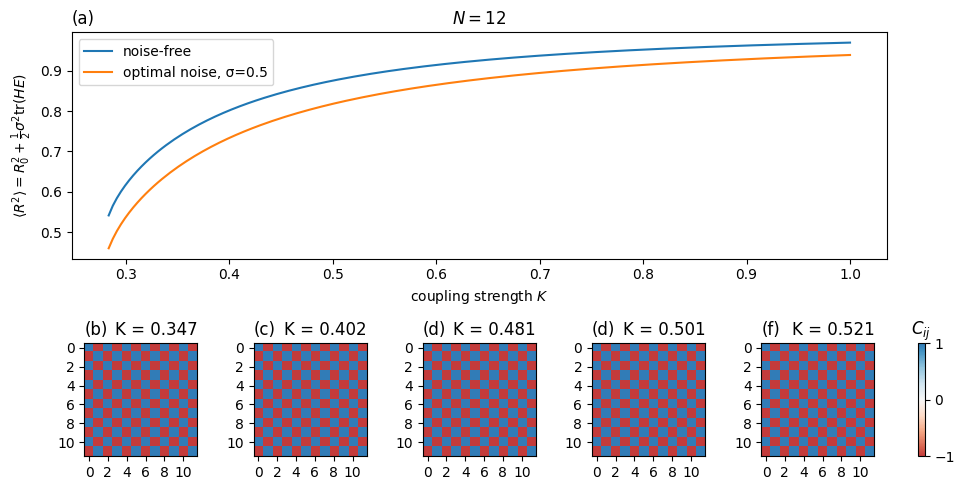

sys:1: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


In [12]:
fig = figure(constrained_layout=true, figsize=(9.75, 5))
gs = fig.add_gridspec(2, 6, height_ratios=[2, 1], width_ratios=[1,1,1,1,1,0.05])

ax1 = fig.add_subplot(element(0, slice(0, 5)))

Ks = data_chain_12["Ks"]
R0s = data_chain_12["R0s"]
σ = 0.5#data_chain_12["σ"]
optvals = data_chain_12["optvals"]
ax1.plot(Ks, R0s, label="noise-free")
ax1.plot(Ks, R0s .+ 0.5*(σ^2)*optvals, label="optimal noise, σ=$(σ)")

ax1.legend()
ax1.set_xlabel(L"coupling strength $K$")
ax1.set_ylabel(L"$\langle R^2 \rangle = R_0^2 + \frac{1}{2} \sigma^2 \operatorname{tr}(HE)$")

ax1.set_title("(a)", loc="left")
ax1.set_title(L"N=12")

ax2 = fig.add_subplot(gs[2,1])

i = 86
draw_C_noticks(ax2, data_chain_12["Copts"][i])
ax2.set_title("(b)", loc="left")
ax2.set_title("K = $(round(data_chain_12["Ks"][i], sigdigits=3))", loc="right")


ax3 = fig.add_subplot(gs[2,2])

i = 100
draw_C_noticks(ax3, data_chain_12["Copts"][i])
ax3.set_title("(c)", loc="left")
ax3.set_title("K = $(round(data_chain_12["Ks"][i], sigdigits=3))", loc="right")

ax4 = fig.add_subplot(gs[2,3])

i = 120
draw_C_noticks(ax4, data_chain_12["Copts"][i])
ax4.set_title("(d)", loc="left")
ax4.set_title("K = $(round(data_chain_12["Ks"][i], sigdigits=3))", loc="right")


ax5 = fig.add_subplot(gs[2,4])

i = 125
draw_C_noticks(ax5, data_chain_12["Copts"][i])
ax5.set_title("(d)", loc="left")
ax5.set_title("K = $(round(data_chain_12["Ks"][i], sigdigits=3))", loc="right")


ax6 = fig.add_subplot(gs[2,5])
ax7 = fig.add_subplot(gs[2,6])

i = 130
sc = draw_C_noticks(ax6, data_chain_12["Copts"][i])
ax6.set_title("(f)", loc="left")
ax6.set_title("K = $(round(data_chain_12["Ks"][i], sigdigits=3))", loc="right")

cb = fig.colorbar(sc, cax=ax7, ticks=[-1,0,1], shrink=0.15, use_gridspec=true)
cb.ax.set_title(L"C_{ij}")

fig.tight_layout()

# fig.savefig("../figures/supp_optimal_K_dep_12.svg", bbox_inches="tight")
# fig.savefig("../figures/supp_optimal_K_dep_12.pdf", bbox_inches="tight")

# New Figure: Power grids

In [28]:
grid_data = load("data/powergrid_ieee_14_fix_Cii.jld2")

grid14_Copts = grid_data["Copts"]
grid14_R0s = grid_data["R0s"]
grid14_optvals = grid_data["optvals"]
grid14_αs = grid_data["αs"]

grid14_Cnorms = [mean(abs.(C)) for C in grid14_Copts];

draw_C_noticks (generic function with 1 method)

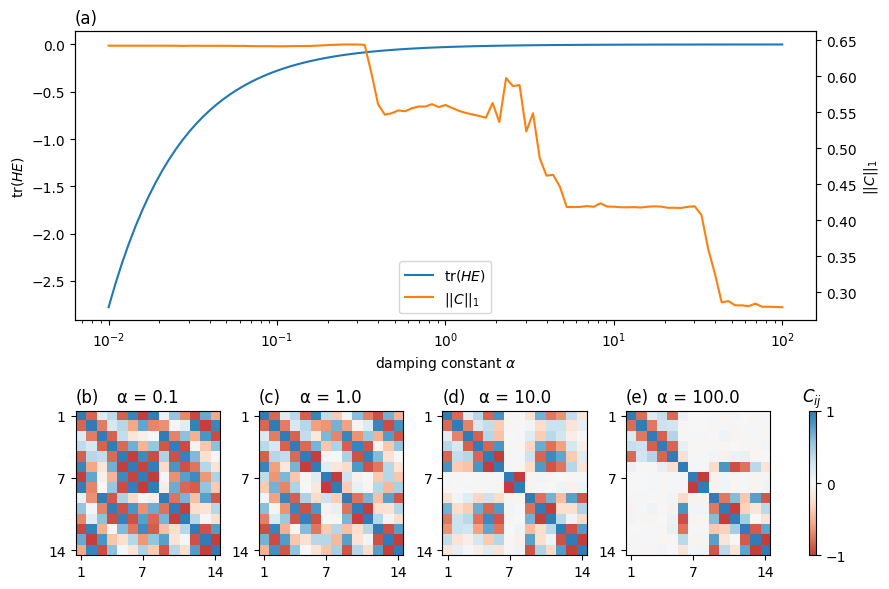

In [33]:
fig = figure(constrained_layout=true, figsize=(9, 6))
gs = fig.add_gridspec(2, 5, height_ratios=[2, 1], width_ratios=[1,1,1,1,0.05])

ax1 = fig.add_subplot(element(0, slice(0, 5)))

h1 = ax1.semilogx(grid14_αs, grid14_optvals, label=L"$\operatorname{tr}(HE)$")

ax1.set_xlabel(L"damping constant $\alpha$")
ax1.set_ylabel(L"$\operatorname{tr}(HE)$")
ax1.set_title("(a)", loc="left")

ax1b = ax1.twinx()
ax1b.semilogx(grid14_αs, grid14_Cnorms, "C1", label=L"$||C||_1$")
h2 = ax1.semilogx(NaN*grid14_αs[1:1], NaN*grid14_Cnorms[1:1], "C1", label=L"$||C||_1$")

ax1b.set_ylabel(L"$||C||_1$")

ax1.legend(loc=8)


ax2 = fig.add_subplot(gs[2,1])

i = 26
draw_C(ax2, grid14_Copts[i])
ax2.set_title("(b)", loc="left")
ax2.set_title("α = $(round(grid14_αs[i], sigdigits=2))")


ax3 = fig.add_subplot(gs[2,2])

i = 51
draw_C(ax3, grid14_Copts[i])
ax3.set_title("(c)", loc="left")
ax3.set_title("α = $(round(grid14_αs[i], sigdigits=2))")

ax4 = fig.add_subplot(gs[2,3])

i = 76
draw_C(ax4, grid14_Copts[i])
ax4.set_title("(d)", loc="left")
ax4.set_title("α = $(round(grid14_αs[i], sigdigits=2))")

ax5 = fig.add_subplot(gs[2,4])
ax6 = fig.add_subplot(gs[2,5])

i = 101
sc = draw_C(ax5, grid14_Copts[i])
cb = fig.colorbar(sc, cax=ax6, ticks=[-1,0,1], shrink=0.15, use_gridspec=true)
cb.ax.set_title(L"C_{ij}")

ax5.set_title("(e)", loc="left")
ax5.set_title("α = $(round(grid14_αs[i], sigdigits=2))")

fig.tight_layout()

fig.savefig("../figures/supp_ieee14_swing.svg", bbox_inches="tight")
fig.savefig("../figures/supp_ieee14_swing.pdf", bbox_inches="tight")

# New Figure: Twisted states

In [18]:
data_twist_q_1 = load("data/twisted_ring_34_fix_Cii_K_2.0_q_1.jld2")
tw_q_1_Copt = data_twist_q_1["Copt"];

data_twist_q_2 = load("data/twisted_ring_34_fix_Cii_K_2.0_q_2.jld2")
tw_q_2_Copt = data_twist_q_2["Copt"];

data_twist_q_3 = load("data/twisted_ring_34_fix_Cii_K_2.0_q_3.jld2")
tw_q_3_Copt = data_twist_q_3["Copt"];

data_twist_q_4 = load("data/twisted_ring_34_fix_Cii_K_2.0_q_4.jld2")
tw_q_4_Copt = data_twist_q_4["Copt"];

data_twist_q_1 = load("data/twisted_ring_35_fix_Cii_K_2.0_q_1.jld2")
tw_q_1_Copt2 = data_twist_q_1["Copt"];

data_twist_q_2 = load("data/twisted_ring_35_fix_Cii_K_2.0_q_2.jld2")
tw_q_2_Copt2 = data_twist_q_2["Copt"];

data_twist_q_3 = load("data/twisted_ring_35_fix_Cii_K_2.0_q_3.jld2")
tw_q_3_Copt2 = data_twist_q_3["Copt"];

data_twist_q_4 = load("data/twisted_ring_35_fix_Cii_K_2.0_q_4.jld2")
tw_q_4_Copt2 = data_twist_q_4["Copt"];

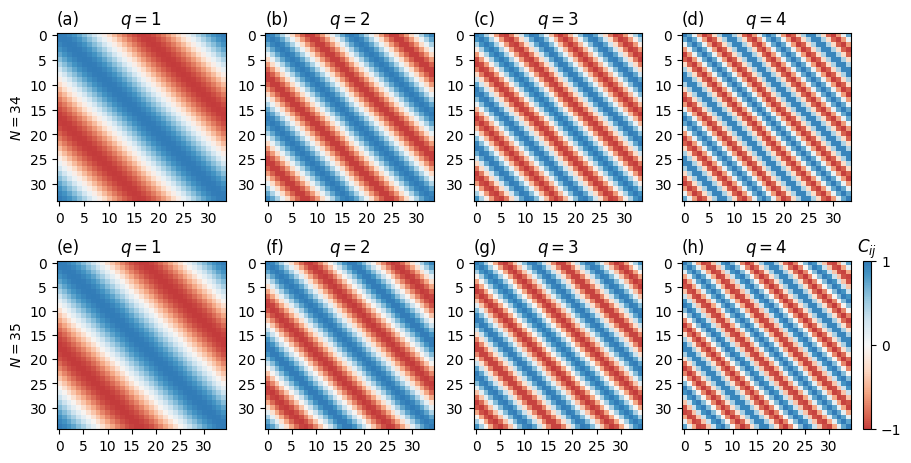

In [30]:
fig = figure(constrained_layout=true, figsize=(9, 4.5))
gs = fig.add_gridspec(2, 5, width_ratios=[1,1,1,1,0.05])

ax2 = fig.add_subplot(gs[1,1])

sc = draw_C_noticks(ax2, tw_q_1_Copt)
ax2.set_title("(a)", loc="left")
ax2.set_title(L"q=1")
ax2.set_ylabel(L"N=34")

ax2 = fig.add_subplot(gs[1,2])

sc = draw_C_noticks(ax2, tw_q_2_Copt)
ax2.set_title("(b)", loc="left")
ax2.set_title(L"q=2")

ax2 = fig.add_subplot(gs[1,3])

sc = draw_C_noticks(ax2, tw_q_3_Copt)
ax2.set_title("(c)", loc="left")
ax2.set_title(L"q=3")

ax2 = fig.add_subplot(gs[1,4])

sc = draw_C_noticks(ax2, tw_q_4_Copt)
ax2.set_title("(d)", loc="left")
ax2.set_title(L"q=4")


ax2 = fig.add_subplot(gs[2,1])

sc = draw_C_noticks(ax2, tw_q_1_Copt2)
ax2.set_title("(e)", loc="left")
ax2.set_title(L"q=1")
ax2.set_ylabel(L"N=35")

ax2 = fig.add_subplot(gs[2,2])

draw_C_noticks(ax2, tw_q_2_Copt2)
ax2.set_title("(f)", loc="left")
ax2.set_title(L"q=2")

ax2 = fig.add_subplot(gs[2,3])

draw_C_noticks(ax2, tw_q_3_Copt2)
ax2.set_title("(g)", loc="left")
ax2.set_title(L"q=3")

ax2 = fig.add_subplot(gs[2,4])

draw_C_noticks(ax2, tw_q_4_Copt2)
ax2.set_title("(h)", loc="left")
ax2.set_title(L"q=4")

cax = fig.add_subplot(gs[2,5])
cb = fig.colorbar(sc, cax=cax, ticks=[-1,0,1], shrink=0.1, use_gridspec=true)
cb.ax.set_title(L"C_{ij}")

# fig.tight_layout()

fig.savefig("../figures/supp_twisted.svg", bbox_inches="tight")
fig.savefig("../figures/supp_twisted.pdf", bbox_inches="tight")

# New Figure: Time series for twisted states

In [92]:
data_tw_q1_10 = load("data/twisted_ring_q_1_10_fix_Cii_K_2.0_sigma_0.25_timeseries.jld2")
tw_q1_ts          = data_tw_q1_10["ts_unif"]
tw_q1_Rsqrs_avg    = data_tw_q1_10["Rsqrs_avg"]
tw_q1_Rsqrs_avg_u  = data_tw_q1_10["Rsqrs_avg_unif"];

data_tw_q2_10 = load("data/twisted_ring_q_2_10_fix_Cii_K_2.0_sigma_0.1_timeseries.jld2")
tw_q2_ts          = data_tw_q2_10["ts_unif"]
tw_q2_Rsqrs_avg    = data_tw_q2_10["Rsqrs_avg"]
tw_q2_Rsqrs_avg_u  = data_tw_q2_10["Rsqrs_avg_unif"];

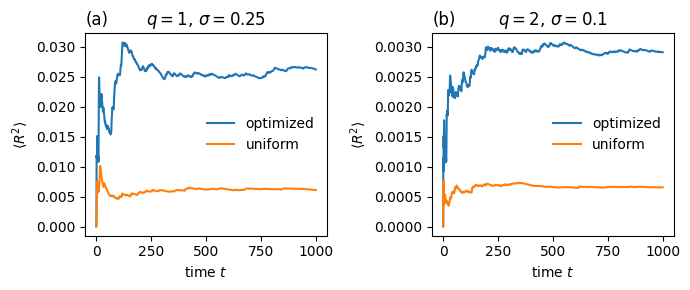

In [96]:
fig, axs = subplots(1, 2, figsize=(7, 3))

ax = axs[1]
ax.plot(tw_q1_ts, tw_q1_Rsqrs_avg, label="optimized")
ax.plot(tw_q1_ts, tw_q1_Rsqrs_avg_u, label="uniform")

ax.set_xlabel(L"time $t$")
ax.set_ylabel(L"\langle R^2 \rangle")

ax.legend(frameon=false)

ax.set_title("(a)", loc="left")
ax.set_title(L"$q=1$, $\sigma=0.25$")

ax = axs[2]
ax.plot(tw_q2_ts, tw_q2_Rsqrs_avg, label="optimized")
ax.plot(tw_q2_ts, tw_q2_Rsqrs_avg_u, label="uniform")

ax.set_xlabel(L"time $t$")
ax.set_ylabel(L"\langle R^2 \rangle")

ax.legend(frameon=false)

ax.set_title("(b)", loc="left")
ax.set_title(L"$q=2$, $\sigma=0.1$")

fig.tight_layout()

fig.savefig("../figures/supp_twisted_timeseries.svg", bbox_inches="tight")
fig.savefig("../figures/supp_twisted_timeseries.pdf", bbox_inches="tight")

# New figure: Dependence on Standard deviations

In [6]:
data_std_10 = load("data/chain_omegas_n_1_m_10.jld2")
σ_ωs_10        = data_std_10["σ_ωs"]
Ks_10          = data_std_10["Ks"]
R0s_all_10     = data_std_10["R0s_all"]
optvals_all_10 = data_std_10["optvals_all"]


data_std_12 = load("data/chain_omegas_n_1_m_12.jld2")
σ_ωs_12        = data_std_12["σ_ωs"]
Ks_12          = data_std_12["Ks"]
R0s_all_12     = data_std_12["R0s_all"]
optvals_all_12 = data_std_12["optvals_all"]

data_std_15 = load("data/chain_omegas_n_1_m_15.jld2")
σ_ωs_15        = data_std_15["σ_ωs"]
Ks_15          = data_std_15["Ks"]
R0s_all_15     = data_std_15["R0s_all"]
optvals_all_15 = data_std_15["optvals_all"]

10-element Vector{Any}:
 Any[NaN, NaN, NaN, NaN, NaN, NaN, NaN, 55.06061877051714, 12.925462471242868, -0.862010637985005  …  -0.26415717660853777, -0.26279967267876636, -0.2614560549365282, -0.26012603125766437, -0.2588094827901969, -0.2575061707924165, -0.2562159064700948, -0.25493848750445897, -0.2536737278950108, -0.25242142786752786]
 Any[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  -0.2638966181163789, -0.26254312602993873, -0.2612033246244288, -0.25987724947733387, -0.2585644816071935, -0.2572648642128121, -0.255978212583021, -0.25470434637107126, -0.2534430641709561, -0.2521941720268507]
 Any[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  -0.26346220330796166, -0.26211537126946705, -0.260782202420287, -0.25946247405687684, -0.25815596710527433, -0.25686249998095917, -0.25558189219915084, -0.25431390243793806, -0.25305843048658566, -0.25181529787363305]
 Any[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  -0.26273807605150956, -0.26140238474641836, -0.26008010

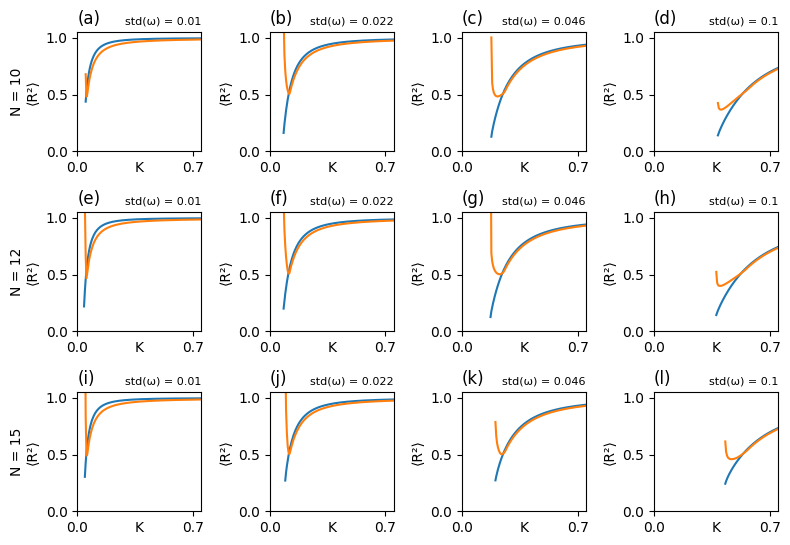

In [41]:
fig, axs = subplots(3, Int64(ceil(length(σ_ωs_10)/3)), figsize=(2*Int64(ceil(length(σ_ωs_10)/3)), 1.85*3))

letters = "abcd"
σ = 0.25
for (ax, optvals, R0s, σ_ω, letter) in zip(axs[1,:], optvals_all_10[1:3:end], R0s_all_10[1:3:end], σ_ωs_10[1:3:end], letters)
    ax.plot(Ks_10, R0s, label="noise-free")
    ax.plot(Ks_10, R0s .+ 0.5*(σ^2)*optvals, label="optimized noise")
    ax.set_xlabel("K", labelpad=-10)
    ax.set_ylabel("⟨R²⟩")
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0, 0.75)
    ax.set_xticks([0, 0.7])
    ax.set_title("std(ω) = $(round(σ_ω, sigdigits=2))", fontsize=8, loc="right")
    ax.set_title("("*letter*")", loc="left")
end


letters = "efgh"
σ = 0.25
for (ax, optvals, R0s, σ_ω, letter) in zip(axs[2,:], optvals_all_12[1:3:end], R0s_all_12[1:3:end], σ_ωs_12[1:3:end], letters)
    ax.plot(Ks_12, R0s, label="noise-free")
    ax.plot(Ks_12, R0s .+ 0.5*(σ^2)*optvals, label="optimized noise")
    ax.set_xlabel("K", labelpad=-10)
    ax.set_ylabel("⟨R²⟩")
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0, 0.75)
    ax.set_xticks([0, 0.7])
    ax.set_title("std(ω) = $(round(σ_ω, sigdigits=2))", fontsize=8, loc="right")
    ax.set_title("("*letter*")", loc="left")
end

letters = "ijkl"
σ = 0.25
for (ax, optvals, R0s, σ_ω, letter) in zip(axs[3,:], optvals_all_15[1:3:end], R0s_all_15[1:3:end], σ_ωs_15[1:3:end], letters)
    ax.plot(Ks_15, R0s, label="noise-free")
    ax.plot(Ks_15, R0s .+ 0.5*(σ^2)*optvals, label="optimized noise")
    ax.set_xlabel("K", labelpad=-10)
    ax.set_ylabel("⟨R²⟩")
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0, 0.75)
    ax.set_xticks([0, 0.7])
    ax.set_title("std(ω) = $(round(σ_ω, sigdigits=2))", fontsize=8, loc="right")
    ax.set_title("("*letter*")", loc="left")
end


axs[1,1].set_ylabel("N = 10\n⟨R²⟩")
axs[2,1].set_ylabel("N = 12\n⟨R²⟩")
axs[3,1].set_ylabel("N = 15\n⟨R²⟩")

fig.tight_layout()

fig.savefig("../figures/supp_omegas.svg", bbox_inches="tight")
fig.savefig("../figures/supp_omegas.pdf", bbox_inches="tight")

# New Figure 3: Optimal noise transition

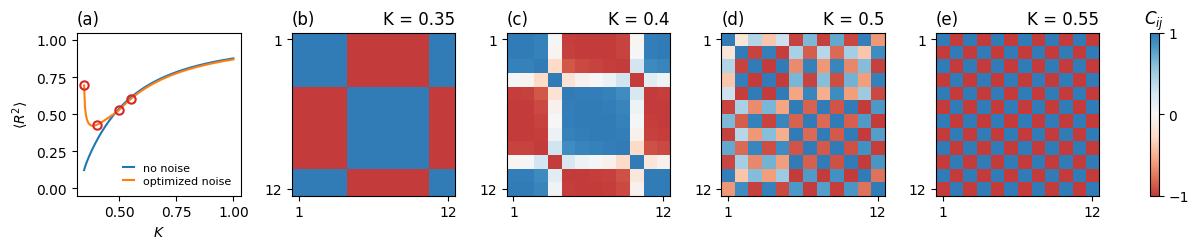

In [27]:
fig = figure(figsize=(12, 2.6))
gs = fig.add_gridspec(1, 6, width_ratios=[1,1,1,1,1,0.05])

is = [86, 100, 125, 138]

Ks = chain_12_Ks
Rsqrs_no = chain_12_Rsqrs_no
Rsqrs_opt = chain_12_Rsqrs_opt
Rsqrs_uni = chain_12_Rsqrs_uni
R0s = chain_12_R0s
σ = 0.5chain_12_σ
Copts = data_chain_12["Copts"]
optvals = data_chain_12["optvals"]

ax = fig.add_subplot(gs[1])
# ax.plot(chain_12_Ks, chain_12_R0s, "k-", label="no noise, theory")
# ax.plot(Ks, Rsqrs_no, color="0.5", label="no noise")
# ax.plot(Ks, Rsqrs_opt, color="C1", label="optimal")
# ax.plot(Ks, Rsqrs_uni, color="C0", alpha=0.5, label="uncorrelated")

ax.plot(Ks, R0s, label="no noise")
ax.plot(Ks, R0s .+ 0.5(σ^2)*optvals, label="optimized noise")

# ax.plot(Ks, R0s .+ 0.5σ^2*optvals)

ax.legend(frameon=false, fontsize=8, handlelength=1, labelspacing=0.25)

ax.set_ylim(-0.05, 1.05)
# ax.set_xlim(-0.05, 1.05)


ax.set_xlabel(L"K")
ax.set_ylabel(L"\langle R^2 \rangle")
ax.set_title("(a)", loc="left")
# ax.set_title(L"$N=12$, $\sigma=0.5$")

ax.plot(Ks[is], R0s[is] .+ 0.5(σ^2)*optvals[is], "o", color="C3", markerfacecolor="none", markeredgewidth=1.5)

# for K in Ks[is]
#     ax.axvline(K, color="0.2", alpha=0.5, lw=0.5)
# end


#inset
# axins = inset_axes(ax, width=0.75, height=0.75)

# axins.plot(chain_11_Ks, chain_11_Rsqrs_no, color="0.5")
# axins.plot(Ks, Rsqrs_opt, color="C1")
# axins.plot(chain_11_Ks, chain_11_Rsqrs_uni, color="C0", alpha=0.5)

# axins.scatter(Ks[is], Rsqrs_opt[is], facecolor="none", 
#     edgecolor="C3", linewidth=1.5, zorder=1000)

# axins.set_xticks([])
# axins.set_yticks([])

# axins.set_xlim(0.9*Ks[is][1], 1.1*Ks[is][end])
# axins.set_ylim(0.37, 0.45)

ax2 = fig.add_subplot(gs[2])

i = is[1]
draw_C_noticks(ax2, Copts[i])

ax2.set_xticks([0, 11])
ax2.set_yticks([0, 11])

ax2.xaxis.set_ticks_position("bottom")

ax2.set_xticklabels([1, 12])
ax2.set_yticklabels([1, 12])

ax2.set_title("(b)", loc="left")
ax2.set_title("K = $(round(Ks[i], sigdigits=2))", loc="right")

ax2 = fig.add_subplot(gs[3])

i = is[2]
draw_C_noticks(ax2, Copts[i])
ax2.set_title("(c)", loc="left")
ax2.set_title("K = $(round(Ks[i], sigdigits=2))", loc="right")


ax2.set_xticks([0, 11])
ax2.set_yticks([0, 11])

ax2.xaxis.set_ticks_position("bottom")

ax2.set_xticklabels([1, 12])
ax2.set_yticklabels([1, 12])

ax2 = fig.add_subplot(gs[4])

i = is[3]
draw_C_noticks(ax2, Copts[i])
ax2.set_title("(d)", loc="left")
ax2.set_title("K = $(round(Ks[i], sigdigits=2))", loc="right")


ax2.set_xticks([0, 11])
ax2.set_yticks([0, 11])

ax2.xaxis.set_ticks_position("bottom")

ax2.set_xticklabels([1, 12])
ax2.set_yticklabels([1, 12])

ax2 = fig.add_subplot(gs[5])

i = is[4]
sc = draw_C_noticks(ax2, Copts[i])
ax2.set_title("(e)", loc="left")
ax2.set_title("K = $(round(Ks[i], sigdigits=2))", loc="right")


ax2.set_xticks([0, 11])
ax2.set_yticks([0, 11])

ax2.xaxis.set_ticks_position("bottom")

ax2.set_xticklabels([1, 12])
ax2.set_yticklabels([1, 12])


cax = fig.add_subplot(gs[6])
cb = fig.colorbar(sc, cax=cax, ticks=[-1,0,1], shrink=0.1)
cb.ax.set_title(L"C_{ij}")

fig.tight_layout()

fig.savefig("../figures/figure_3_v2.svg", bbox_inches="tight")
fig.savefig("../figures/figure_3_v2.pdf", bbox_inches="tight")